In [1]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from gensim.models import Word2Vec 
import matplotlib.pyplot as plt
%matplotlib inline

import warnings;
warnings.filterwarnings('ignore')

C:\Users\hungu\anaconda.x\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
data = pd.read_excel('Online Retail.xlsx')
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
data.shape

(541909, 8)

In [4]:
data.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

In [5]:
data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [6]:
data.dropna(inplace=True)

In [7]:
data['StockCode'] = data['StockCode'].astype('str')

In [8]:
customers = data['CustomerID'].unique().tolist()
len(customers)

4372

In [9]:
random.shuffle(customers)

customer_train = [customers[i] for i in range(round(0.9*len(customers)))]

train = data[data['CustomerID'].isin(customer_train)]
validation = data[~data['CustomerID'].isin(customer_train)]

In [10]:
train.shape, validation.shape

((368588, 8), (38241, 8))

In [11]:
purchases_train = []

for i in tqdm(customer_train):
    t = train[train['CustomerID']== i]['StockCode'].tolist()
    purchases_train.append(t)

100%|█████████████████████████████████████████████████████████████████████████████| 3935/3935 [00:04<00:00, 838.37it/s]


In [12]:
purchases_validation = []

for i in tqdm(validation['CustomerID'].unique()):
    t = validation[validation['CustomerID']== i]['StockCode'].tolist()
    purchases_validation.append(t)

100%|██████████████████████████████████████████████████████████████████████████████| 437/437 [00:00<00:00, 1284.55it/s]


In [13]:
model = Word2Vec(window=10, sg=1, hs=0,
                 negative=10, alpha=0.03, min_alpha=0.0007, seed=14)

model.build_vocab(purchases_train, progress_per=200)

model.train(purchases_train, total_examples=model.corpus_count,
            epochs=10, report_delay=1)

(3649320, 3685880)

In [14]:
model.init_sims(replace=True)

In [15]:
print(model)

Word2Vec(vocab=3182, size=100, alpha=0.03)


In [16]:
X = model[model.wv.vocab]
X.shape

(3182, 100)

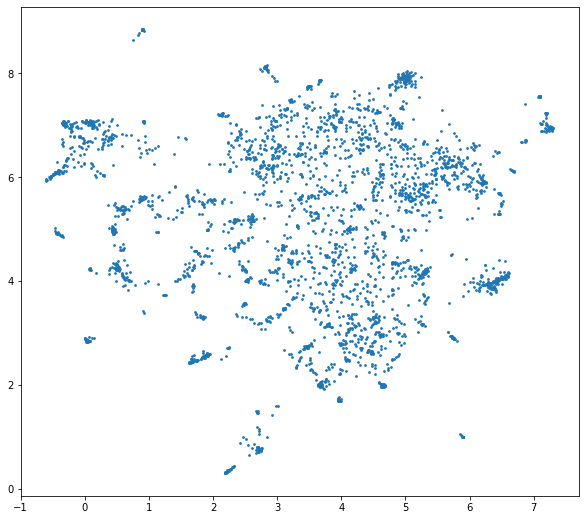

In [17]:
import umap

cluster_embedding = umap.UMAP(n_neighbors=50, min_dist=0.0,
                              n_components=2, random_state=42).fit_transform(X)

plt.figure(figsize=(10,9))
plt.scatter(cluster_embedding[:, 0], cluster_embedding[:, 1], s=3, cmap='Spectral')

In [18]:
products = train[['StockCode','Description']]

products.drop_duplicates(inplace=True, subset='StockCode', keep='last')

In [19]:
products.tail(3)

,StockCode,Description
541906,23254,CHILDRENS CUTLERY DOLLY GIRL
541907,23255,CHILDRENS CUTLERY CIRCUS PARADE
541908,22138,BAKING SET 9 PIECE RETROSPOT


In [20]:
product_dictionary = products.groupby('StockCode')['Description'].apply(list).to_dict()

In [26]:
product_dictionary['23346']

['SPACEBOY BEAKER']

In [22]:
def get_similar_products(product, num = 7):
    ms = model.similar_by_vector(product, topn= num+1)[1:]
    temp = []
    for j in ms:
        pair = (product_dictionary[j[0]][0], j[0])
        temp.append(pair)
    return temp

In [25]:
get_similar_products(model['23256'])

[('CHILDRENS CUTLERY DOLLY GIRL ', '23254'),
 ('CHILDRENS CUTLERY CIRCUS PARADE', '23255'),
 ('CHILDRENS CUTLERY POLKADOT PINK', '84997D'),
 ('SPACEBOY CHILDRENS BOWL', '23290'),
 ('SPACEBOY LUNCH BOX ', '22629'),
 ('SPACEBOY BEAKER', '23346'),
 ('ROUND SNACK BOXES SET OF 4 FRUITS ', '22328')]